In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Hyperbolic Spaces

This notebook shows how define and evaluate kernels on the two-dimensional hyperbolic space $\mathbb{H}_2$.

Handling higher-dimensional hyperbolic spaces $\mathbb{H}_d$ for $d \geq 2$ is essentially the same.
We chose to showcase $\mathbb{H}_2$ here because (1) it is probably the most well known case (2) it is easy to visualize.

**Note:** the points on the hyperbolic space $\mathbb{H}_d$ are represented by $d+1$-dimensional vectors (`array`s of the suitable backend) satisfying $x_1^2 - x_2^2 - \ldots - x_{d+1}^2 = 1$ (i.e. lying on the hyberboloid).

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Hyperbolic
from geometric_kernels.kernels import MaternFeatureMapKernel
from geometric_kernels.kernels.feature_maps import rejection_sampling_feature_map_hyperbolic

import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional hyperbolic space $\mathbb{H}_2$.

In [3]:
hyperbolic_space = Hyperbolic(dim=2)

For *non-compact symmetric spaces* such as the `Hyperbolic`, the class `MaternFeatureMapKernel` should be used.

## Theory (Optional Reading)
### General Theory Behind `MaternFeatureMapKernel` for Non-compact Symmetric Spaces

The theory for *non-compact symmetric spaces* (like the hyperbolic spaces or manifolds of positive definite matrices) is quite different to _compact_ spaces (which we call `DiscreteSpectrumSpace`s), where the kernel is a sum of a _series_, that can be approximated via truncation, here kernels are represented by integrals approximated by Monte Carlo.

More specifically, for non-compact symmetric spaces an analog of the *random Fourier features* technique of [Rahimi Recht (2007)](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) exits.
In the Euclidean case, closed form expressions for the kernels are available and random Fourier features are only used to speed up computations.
No closed form expressions are (usually) available for general non-compact symmetric spaces.
Because of that, random Fourier features are the means of computing kernels in this case.

A complete mathematical treatise can be found in [1].
Here we briefly present the basics. The usual Euclidean random Fourier features are given by

$$
k(x, x') = \int_{\mathbb{R}^d} S(\lambda) e^{2 \pi i \langle x - x', \rangle} \mathrm{d} \lambda \approx \frac{1}{L} \sum_{l=1}^L e^{2 \pi i \langle x - x', \lambda_l\rangle}
\qquad
\lambda_l \sim S(\lambda)
$$
where $S(\cdot)$ which is the Gaussian density if $\nu = \infty$ and Student $t$ density with $\nu$ if $\nu < \infty$.

On a non-compact symmetric space the following holds instead:
$$
k(x, x') = \int_{\mathbb{R}^r} S(\lambda) \pi^{(\lambda)}(x, x') c(\lambda)^{-2} \mathrm{d} \lambda \approx \frac{1}{L} \sum_{l=1}^L \pi^{(\lambda_l)}(x, x')
\qquad
\lambda_l \sim c(\lambda)^{-2} S(\lambda)
$$
where $r$ is the *rank* of the symmetric space, $\pi^{(\lambda)}$ are called *zonal spherical functions* and $c(\lambda)$ is the *Harish-Chandra $c$ function*.
Here, $r$ and $c$ can be computed exactly using algebraic-only considerations.
On the other hand, $\pi^{(\lambda_l)}(x, x')$ are integrals that need to be numerically approximated.
There exists several ways of doing this, but the most important one is as follows:
$$
\pi^{(\lambda_l)}(x, x') = \mathbb{E}_{h \sim \mu_H}
e^{\langle i \lambda + \rho, \,a(h, x)\rangle}
\overline{
e^{\langle i \lambda + \rho, \,a(h, x')\rangle}}
\approx
\frac{1}{P} \sum_{p=1}^P
e^{\langle i \lambda + \rho, \,a(h_p, x)\rangle}
\overline{
e^{\langle i \lambda + \rho, \,a(h_p, x')\rangle}}
\qquad \qquad
h_p \sim \mu_H
$$
where $\mu_H$ is some measure which is usually easy to sample from.
The righ-hand side here is obviously an inner product.
Same is true for the result of substituting this approximation of $\pi^{(\lambda_l)}(x, x')$ into the approximation of $k(x, x')$.
More specifically, defining
$$
\phi(x) =
\frac{1}{\sqrt{P L}}
(
e^{\langle i \lambda_1 + \rho, \,a(h_1, x)\rangle},
\ldots,
e^{\langle i \lambda_1 + \rho, \,a(h_P, x)\rangle},
\ldots,
e^{\langle i \lambda_L + \rho, \,a(h_1, x)\rangle},
\ldots,
e^{\langle i \lambda_L + \rho, \,a(h_P, x)\rangle})
$$
we have
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle.
$$

The class `MaternFeatureMapKernel` defines kernel approximations of form $k(x, x') \approx \langle \phi(x), \phi(x') \rangle$ where the feature map $\phi(\cdot)$ is determined by a feature map function like `rejection_sampling_feature_map_hyperbolic`.

## Defining a Kernel

To initialize `MaternFeatureMapKernel`, you provide three parameters.
First, the `space`, in our case this is the `hyperbolic_space` we have just created above.
The second parameter, `feature_map`, desrves a separate description.
The third parameter is a random generator `key`.

We start with defining a *feature map*. Intuitively, this is analogous to sampling random feature (cosines or complex exponentials) in a random Fourier feature expansion. The parameter `num_random_phases` determins the number of these features. We use 3000 here, it though you can often make do with less.

In [4]:
feature_map = rejection_sampling_feature_map_hyperbolic(hyperbolic_space, num_random_phases=3_000)

We define randomness

In [5]:
key = np.random.RandomState(seed=1234)

Now we are ready to create a generic Matérn kernel.

In [6]:
kernel = MaternFeatureMapKernel(hyperbolic_space, feature_map, key)

To support JAX, our classes do not contain a *state*, it is external.
The next line initializes the *state* which is composed of two parts: `params`, a dictionary with kernel parameters, and `state`, a dictionary containing the eigenpairs.

`params` are initialized with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [7]:
params, state = kernel.init_params_and_state()
print('params:', params)
print('state:', state)

params: {'nu': array(inf), 'lengthscale': array(1.)}
state: {}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [8]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` random points on the sphere $\mathbb{H}_2$.
Since the hyperbolic spaces are noncompact, the sampling cannot be uniform, we use TODO.

In [9]:
# key = np.random.RandomState(1234)

# key, xs = hyperbolic_space.random(key, 10)

xs = hyperbolic_space.random_point(10)

print(xs)

[[ 1.27032772 -0.45956523  0.63445435]
 [ 1.32156933 -0.30861879  0.80703155]
 [ 1.21073652  0.45725328  0.50675671]
 [ 1.40383833 -0.17529238 -0.96955384]
 [ 1.33310545 -0.10240853  0.87560415]
 [ 1.30750762 -0.5573265  -0.63163546]
 [ 1.0892506  -0.24904393 -0.35276619]
 [ 1.47169849  0.4815318   0.96644896]
 [ 1.10373615  0.38095665  0.27038031]
 [ 1.42841727 -0.91846815 -0.44361264]]


Now we evaluate the two kernel matrices.

In [10]:
kernel_mat_32  = kernel.K(params_32,  state, xs, xs)
kernel_mat_inf = kernel.K(params_inf, state, xs, xs)

Finally, we visualize these matrices using `imshow`.

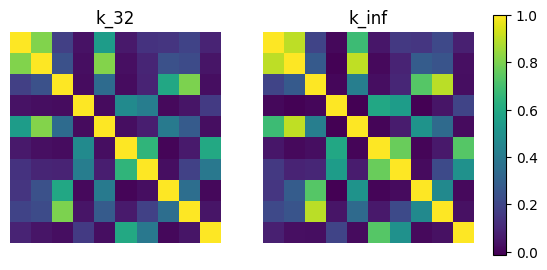

In [11]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

The sphere $\mathbb{S}_2$ is one of the few manifolds we can easily visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(\text{pole}, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
The `base_point` is the center of the Poincaré disk.
The `other_points` is defined as a grid thereon.
Here we exploit the fact that `Hyperbolic` inherits from `geomstats` [Hyperbolic](https://geomstats.github.io/geometry.html#module-geomstats.geometry.hyperbolic).

We define `base_point` and `other_points` in the next cell.

In [12]:
base_point = hyperbolic_space.from_coordinates(np.r_[0, 0], "intrinsic").reshape(1, 3)

s = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(s, s)
other_points = np.c_[xx.ravel(), yy.ravel()]
other_points = hyperbolic_space.from_coordinates(other_points, "intrinsic")

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [13]:
kernel_vals_32  = kernel.K(params_32,  state, base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, state, base_point, other_points)

Finally, we are ready to plot the results.

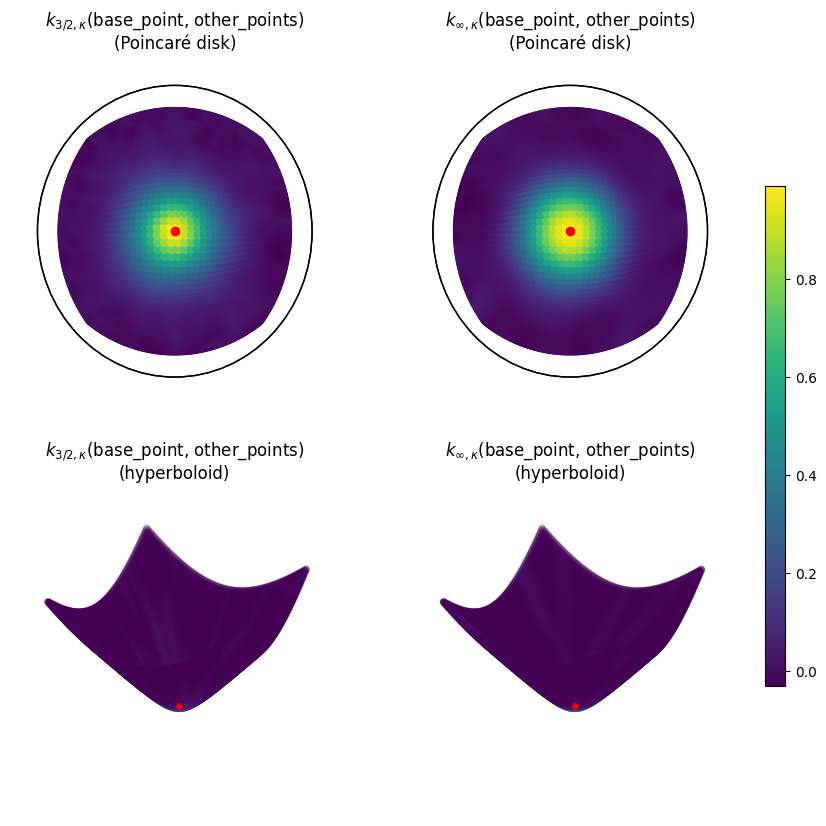

In [14]:
# fig, (ax1, ax2) = plt.subplots(figsize= (10, 10), nrows=2, ncols=2)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, projection='3d', computed_zorder=False)
ax4 = fig.add_subplot(2, 2, 4, projection='3d', computed_zorder=False)

cmap = plt.get_cmap('viridis')

visualization.plot(other_points, space="H2_poincare_disk", c=kernel_vals_32,  cmap=cmap, ax=ax1)
visualization.plot(other_points, space="H2_poincare_disk", c=kernel_vals_inf, cmap=cmap, ax=ax2)
ax3.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=cmap(kernel_vals_32[0]))
ax4.scatter(other_points[:, 2], other_points[:, 1], other_points[:, 0],
                         c=cmap(kernel_vals_inf[0]))


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3._axis3don = False
ax4._axis3don = False

# plot the base point
visualization.plot(base_point, space="H2_poincare_disk", c='red', ax=ax1)
visualization.plot(base_point, space="H2_poincare_disk", c='red', ax=ax2)
ax3.scatter(base_point[0, 2], base_point[0, 1], base_point[0, 0], s=10, c='r', marker='D')
ax4.scatter(base_point[0, 2], base_point[0, 1], base_point[0, 0], s=10, c='r', marker='D')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

# add space for color bar
ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$'   '\n(Poincaré disk)')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$' '\n(Poincaré disk)')
ax3.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$'   '\n(hyperboloid)')
ax4.set_title('$k_{\infty, \kappa}($base_point, other_points$)$' '\n(hyperboloid)')

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Citation

If you are using hyperbolic spaces and GeometricKernels, please consider citing

```
@article{azangulov2023,
    title={Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2301.13088},
    year={2023}
}
```